# AB Тестирование

Компания разработала новую веб-страницу, чтобы увеличить количество платящих пользователей за свой продукт. Они проводят тест AB, чтобы увидеть результаты этой новой страницы. Создаются две группы одинакового размера в качестве контрольной и экспериментальной группы, обозначенные A и B. Лечебной группе (B) представлена ​​новая веб-страница, а контрольной группе (A) — старая, и запускается эксперимент. Данные собираются для обеих групп, а затем применяется проверка гипотез, чтобы определить, является ли разница значительной или нет.

Шаги AB теста:
- Создание гипотезы: Новая страница увеличила количество платящих пользователей
- Проверка предположений
- Тестирование гипотезы
- Интерпретация результатов на основе значения p-value.

**Описание выборки**

```
user_id: Уникальный пользователь
timestamp: Время
group: тестовая и контрольная группа
landing_page: старая и новая страницы
converted: Статус регистрации после просмотра страницы (0-1)
```

H0: нет статистически значимой разницы между старой и новой страницей.

H1: существует статистически значимая разница между старой и новой страницей.

Если значение p меньше 0,05, оно считается значимым и будет использоваться непараметрический тест (критерий Манвитней). В противном случае параметрический тест (t-тест)

Гипотеза будет сделана на основе значения p, полученного в результате параметрического/непараметрического теста, который мы проведем. Этот результат ответит на вопрос: есть ли существенная разница между новой и старой страницей?

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\Daily\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("ab_data.csv")

## Исследование данных

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
print(df.shape)
df = df.drop_duplicates(subset= 'user_id', keep= False)
print(df.shape)

(294480, 5)
(286690, 5)


In [9]:
df.groupby(['group','landing_page']).agg({'landing_page': lambda x: x.value_counts()})

,,landing_page
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [10]:
df.groupby(['group','landing_page']).agg({'converted': 'mean'})

,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


In [11]:
pd.DataFrame(df.loc[:,'landing_page'].value_counts(normalize = True) * 100)

,proportion
landing_page,
new_page,50.018138
old_page,49.981862


In [12]:
df[((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) ]

,user_id,timestamp,group,landing_page,converted


## AB Тестирование

Если значение p меньше 0,05, оно считается значимым и будет использоваться непараметрический тест (критерий Манвитней). В противном случае параметрический тест (t-тест)

### Тест на нормальность (тест Шапиро-Уилка)

H0: Принято предположение о нормальном распределении.

H1: Предположение о нормальном распределении не предусмотрено

Тест Шапиро-Уилка является тестом на нормальность. Он используется для определения того, соответствует ли выборка нормальному распределению.

Эта функция возвращает тестовую статистику и соответствующее p-значение.

Если p-значение ниже определенного уровня значимости, то у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

In [13]:
test_stat, pvalue = shapiro(df.loc[df["landing_page"] == "old_page", "converted"])
print("p-value:",pvalue)
print("test_stat:",test_stat)

p-value: 0.0
test_stat: 0.3792334198951721


In [14]:
test_stat, pvalue = shapiro(df.loc[df["landing_page"] == "new_page", "converted"])
print("p-value:",pvalue)
print("test_stat:",test_stat)

p-value: 0.0
test_stat: 0.37685757875442505


Значение p <0,05, поэтому предположение о нормальности не предусмотрено. мы будем использовать непараметрический тест

### Тест Левена

H0: Отклонения однородны.

H1: Отклонения неоднородны

Тест Левена используется для определения того, имеют ли две или более группы одинаковые отклонения. Он широко используется, потому что многие статистические тесты предполагают, что группы имеют одинаковую дисперсию, а тест Левена позволяет определить, выполняется ли это предположение.

In [15]:
test_stat, pvalue = levene(df.loc[df["landing_page"] == "new_page", "converted"],
                           df.loc[df["landing_page"] == "old_page", "converted"])
print("p-value:",pvalue)  
print("test_stat:",test_stat)

p-value: 0.2322897281547632
test_stat: 1.4267917566652295


Отклонения однородны

## Проверка гипотезы
непараметрический тест с критерием Маннуитнею

H0: нет статистически значимой разницы между старой и новой страницей.

H1: существует статистически значимая разница между старой и новой страницей.


In [16]:
test_stat, pvalue = mannwhitneyu(df.loc[df["landing_page"] == "new_page", "converted"],
                                 df.loc[df["landing_page"] == "old_page", "converted"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 10259026653.0000, p-value = 0.2323


p-значение (0,2323) > 0,05 Мы не можем отвергнуть ноль. нет статистически значимой разницы между новой страницей и старой страницей, поэтому она не приносит прибыли

# Временные ряды

## Тренд

Тренд — это долгосрочное изменение в данных, которое может быть восходящим (рост), нисходящим (падение) или горизонтальным (без изменений). Он представляет собой общее направление движения данных.
Посмотрим на примере:

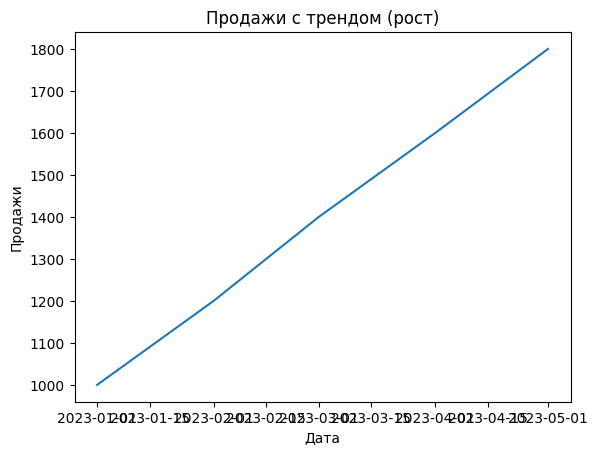

In [17]:
from matplotlib import pyplot as plt
# Создаем dataset с данными о продажах с трендом
data_trend = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
              'Продажи': [1000, 1200, 1400, 1600, 1800]}

df_trend = pd.DataFrame(data_trend)

# Преобразуем столбец 'Дата' в формат даты
df_trend['Дата'] = pd.to_datetime(df_trend['Дата'])

# Построим график продаж с трендом
plt.plot(df_trend['Дата'], df_trend['Продажи'])
plt.title('Продажи с трендом (рост)')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

## Сезонность

Сезонность — это периодические колебания в данных, которые повторяются через равные временные интервалы. Сезонность может быть годовой, месячной, недельной и т. д. Она связана с событиями, которые регулярно влияют на данные

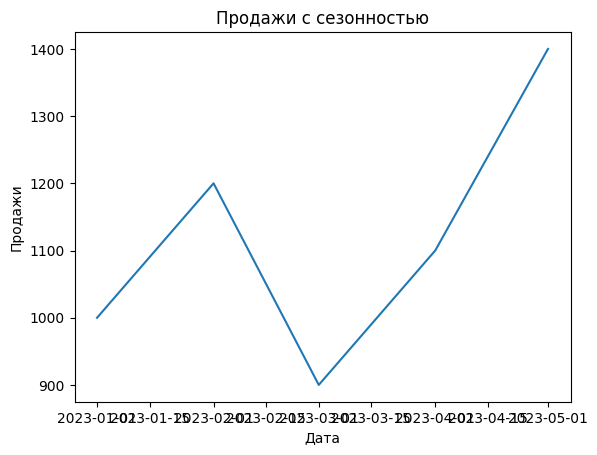

In [18]:
# Создаем dataset с данными о продажах с сезонностью
data_seasonal = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                 'Продажи': [1000, 1200, 900, 1100, 1400]}

df_seasonal = pd.DataFrame(data_seasonal)

# Преобразуем столбец 'Дата' в формат даты
df_seasonal['Дата'] = pd.to_datetime(df_seasonal['Дата'])

# Построим график продаж с сезонностью
plt.plot(df_seasonal['Дата'], df_seasonal['Продажи'])
plt.title('Продажи с сезонностью')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

## Шум
Шум (остаток) — это случайные изменения в данных, которые не могут быть объяснены трендом или сезонностью. Он представляет собой нерегулярные колебания и вариации в данных.

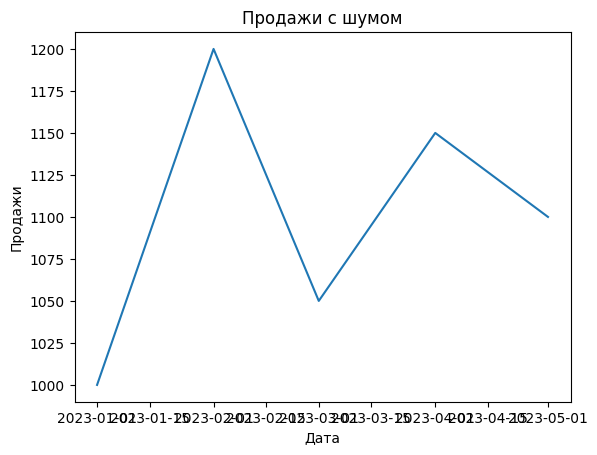

In [19]:
# Создаем dataset с данными о продажах с шумом
data_noise = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
              'Продажи': [1000, 1200, 1050, 1150, 1100]}

df_noise = pd.DataFrame(data_noise)

# Преобразуем столбец 'Дата' в формат даты
df_noise['Дата'] = pd.to_datetime(df_noise['Дата'])

# Построим график продаж с шумом
plt.plot(df_noise['Дата'], df_noise['Продажи'])
plt.title('Продажи с шумом')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

## Декомпозиция временного ряда

Выявление компонентов временного ряда (time series decomposition) предполагает его разложение на тренд, сезонность и случайные колебания.
Декомпозиция временного ряда выделяет и изучает составляющие временного ряда: систематическую составляющую (тренд, сезонность) и случайную (нерегулярную) компоненту или остаток

Дадим несколько неформальных определений.

Тренд — долгосрочное изменение уровня ряда.
Сезонность предполагает циклические изменения уровня ряда с постоянным периодом.
Случайные колебания — непрогнозируемое случайное изменение ряда..ов ряда.

Питоне в модуле statsmodels есть функция seasonal_decompose(). Воспользуемся ей для визуализации компонентов ряда.

Перед этим импортируем второй датасет для последующего сравнения.

In [20]:
births = pd.read_csv('births.csv', index_col = 'Date', parse_dates = True)
births.sort_index(inplace=True)
births.head(3)

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30


In [21]:
passengers = pd.read_csv("passengers.csv", index_col="Month", parse_dates = True)
passengers.sort_index(inplace=True)
passengers

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


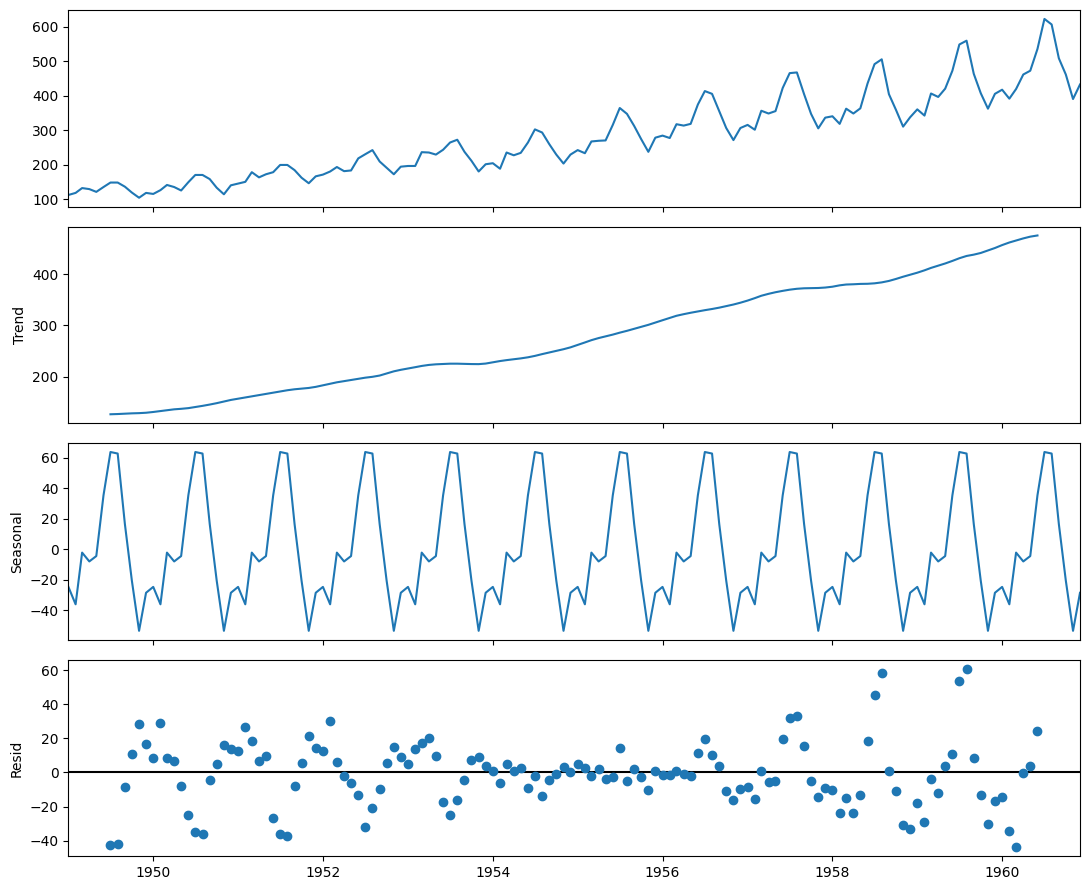

In [22]:
# Теперь давайте разложим наш временной ряд по авиаперевозкам на компоненты.

# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


# применяем функцию к данным о перевозках
decompose = seasonal_decompose(passengers)
decompose.plot()
 
plt.show()

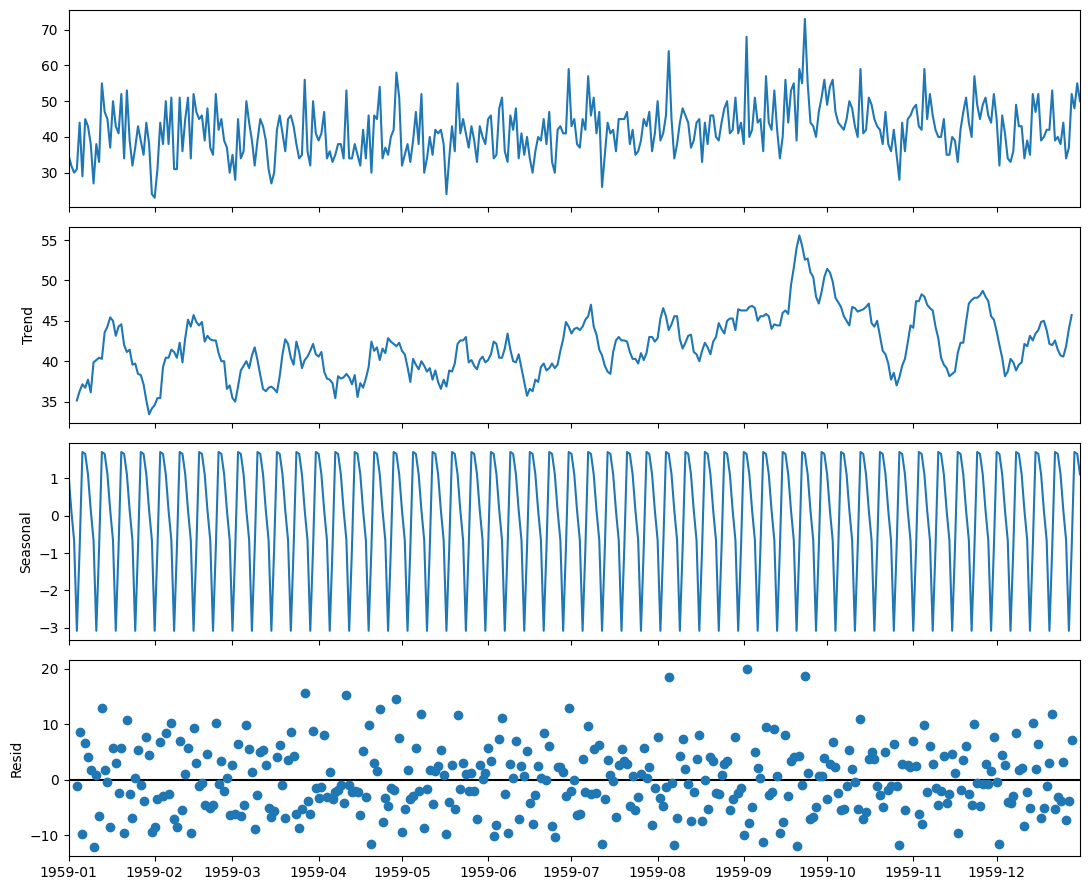

In [23]:
# Сделаем то же самое с данными о рождаемости.
decompose = seasonal_decompose(births)
decompose.plot()
 
plt.show()

## Cтационарность
Стационарность — одно из важнейших свойств временных рядов. 

Стационарный ряд — это ряд, в котором статистические характеристики, такие как среднее и дисперсия, остаются постоянными во времени. Это свойство позволяет нам строить надежные модели и прогнозировать будущие значения.

Понимание того, стационарные ли у нас данные или нестационарные важно для последующего моделирования.

Стационарность процесса можно оценить визуально. Датасет о перевозках демонстрирует очевидный тренд и сезонность, в то время как в наборе данных о рождаемости этого не видно.
Для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test).

В данном случае гипотезы звучат следующим образом:

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном

Применим этот тест к обоим датасетам. Используем пороговое значение, равное 0,05 (5%).

In [24]:
# импортируем необходимую функцию 
from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(passengers['#Passengers'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


Как мы видим, вероятность (p-value) для данных о перевозках существенно выше 0,05. Мы не можем отвергнуть нулевую гипотезу. Процесс нестанионарный. Проведем тест для второго набора данных.

In [25]:
# теперь посмотрим на данные о рождаемости
adf_test = adfuller(births['Births'])
 
# выведем p-value
print('p-value = ' +str(adf_test[1]))

p-value = 5.2434129901498554e-05


Результат существенно меньше 5%. Временной ряд стационарен.
Надо сказать, что наша визуальная оценка полностью совпала с математическими вычислениями.

# Предсказазания по временному ряду

На сегодняшнем занятии мы познакомимся с двумя типами моделей: экспоненциальное сглаживание и модель ARMA (и ее более продвинутые версии, ARIMA, SARIMA и SARIMAX).

## Модель ARMA

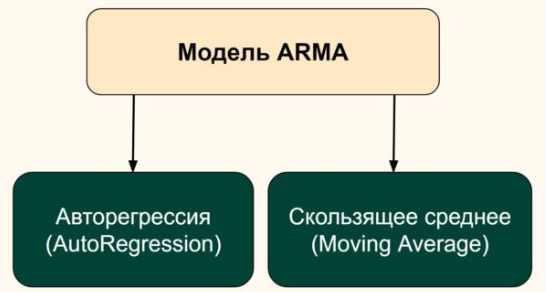

**Авторегрессия** (autoregressive model, AR) — это регрессия ряда на собственные значения в прошлом. Другими словами, наши признаки в модели обычной регрессии мы заменяем значениями той же переменной, но за предыдущие периоды.
Когда мы прогнозируем значение в период t с помощью данных за предыдущий период (AR(1)), уравнение будет выглядеть следующим образом.
$y_t=c+\phi*y_{t-1}$
где c — это константа, $\phi$ — вес модели, $y_{t–1}$ — значение в период _t – 1_.
То, сколько предыдущих периодов использовать определяется параметром p. Обычно записывается как AR(p).ибку.

**Модель скользящего среднего** (moving average, MA) помогает учесть случайные колебания или отклонения (ошибки) истинного значения от прогнозного. Можно также сказать, что модель скользящего среднего — это авторегрессия на ошибку.

! Cкользящее среднее временного ряда и модель скользящего среднего — это разные понятия.

Если использовать ошибку только предыдущего наблюдения, то уравнение будет выглядеть следующим образом.
$y_t=\mu+φ*\epsilon_{t-1}$

где μ — это среднее значение временного ряда, φ — вес модели, $ε_{t–1}$ — ошибка в период _t – 1_.
Такую модель принято называть моделью скользящего среднего с параметром q = 1 или MA(1). Разумеется, параметр q может принимать и другие значения (MA(q)).


Модель ARMA с параметрами (или как еще говорят порядками, orders) p и q или ARMA(p, q) позволяет описать любой стационарный временной ряд.

ARMA предполагает, что в данных отсутствует тренд и сезонность (данные стационарны). Если данные _нестационарны,_ нужно использовать более сложные версии этих моделей:
- **ARIMA**, здесь добавляется компонент Integrated (I), который отвечает за удаление тренда (сам процесс называется дифференцированием); и
- **SARIMA**, эта модель учитывает сезонность (Seasonality, S)
- **SARIMAX** включает еще и внешние или экзогенные факторы (eXogenous factors, отсюда и буква X в названии), которые напрямую не учитываются моделью, но влияют на нее.

Параметров у модели SARIMAX больше. Их полная версия выглядит как SARIMAX(p, d, q) x (P, D, Q, s). В данном случае, помимо известных параметров p и q, у нас появляется параметр d, отвечающий за тренд, а также набор параметров (P, D, Q, s), отвечающих за сезонность.
Теперь давайте воспользуемся моделью SARIMAX для прогнозирования авиаперевозок.

In [26]:
# обучающая выборка будет включать данные до декабря 1959 года включительно
train = passengers[:'1959-12']
 
# тестовая выборка начнется с января 1960 года (по сути, один год)
test = passengers['1960-01':]

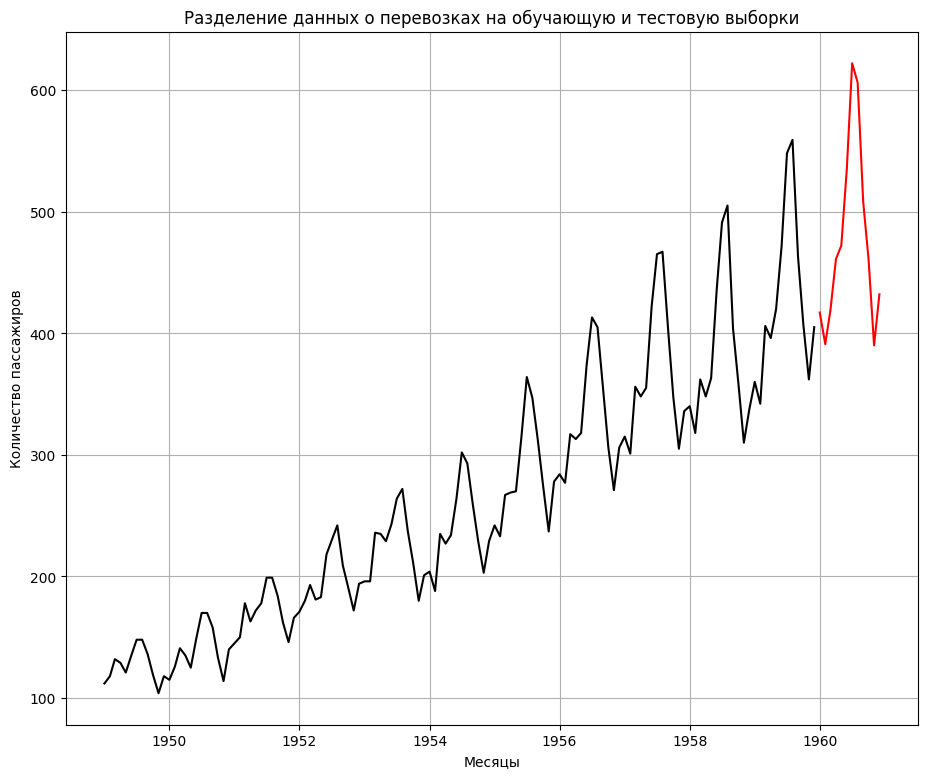

In [27]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

Далее нам нужно обучить модель. При обучении модели SARIMAX, самое важное — правильно подобрать гиперпараметры, о которых говорилось выше. Процесс подбора гиперпараметров достаточно сложен, и сегодня мы воспользуемся уже готовыми значениями.

In [28]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train, 
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 12))
 
# применим метод fit
result = model.fit()

Теперь мы готовы делать прогноз. Вначале сделаем тестовый прогноз, соответствующий периоду тестовой выборки (1960 год), для того, чтобы оценить качество работы модели.

In [29]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

1960-01-01    422.703385
1960-02-01    404.947177
1960-03-01    466.293256
1960-04-01    454.781294
1960-05-01    476.848625
1960-06-01    527.162823
1960-07-01    601.449806
1960-08-01    610.821687
1960-09-01    513.229983
1960-10-01    455.692615
1960-11-01    409.200042
1960-12-01    450.754156
Freq: MS, Name: predicted_mean, dtype: float64

Построим соответствующий график.

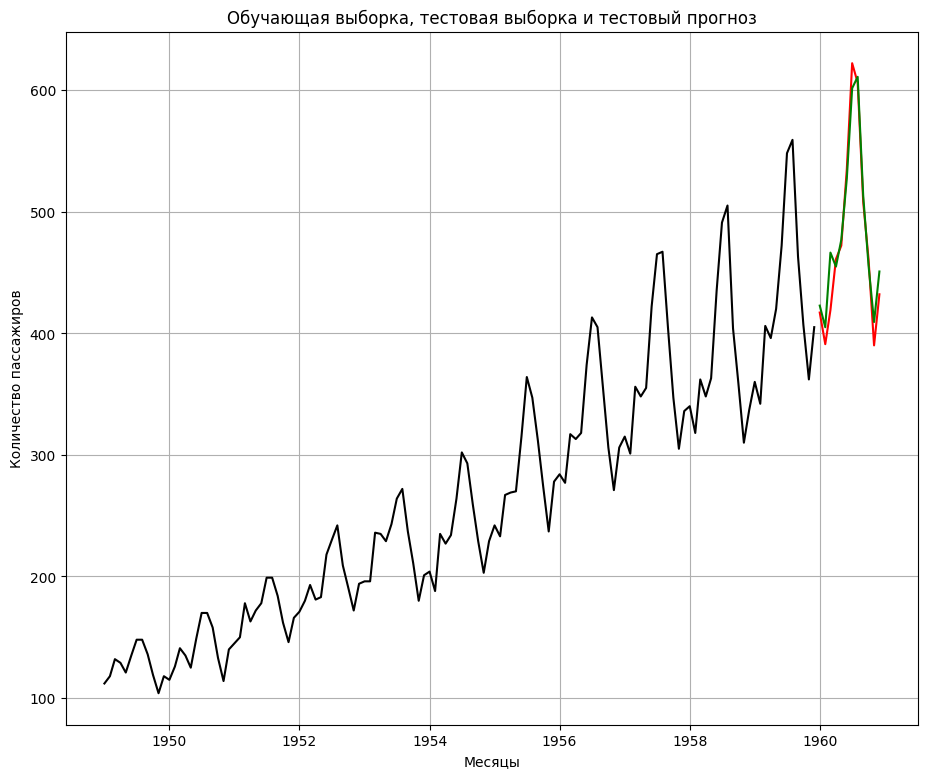

In [30]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

В целом модель хорошо описывает временной ряд. Мы также можем использовать знакомые нам метрики среднеквадратической ошибки (MSE) и корня среднеквадратической ошибки (RMSE) для оценки качества.

In [33]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB 435.7 kB/s eta 0:00:22
   ---------------------------------------- 0.0/9.2 MB 435.7 kB/s eta 0:00:22
   ---------------------------------------- 0.0/9.2 MB 435.7 kB/s 


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\Daily\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [35]:
# импортируем метрику
import numpy as np
from sklearn.metrics import mean_squared_error

# рассчитаем MSE

print(mean_squared_error(test, predictions))

# и RMSE

print(np.sqrt(mean_squared_error(test, predictions)))

317.39562152839056
17.815600509901163


Теперь можно делать прогноз на будущее. Возьмём горизонт равный трем годам (1961, 1962 и 1963 год). Всего должно получиться 36 прогнозных значений.

In [36]:
# прогнозный период с конца имеющихся данных
start = len(passengers)
 
# и закончится 36 месяцев спустя
end = (len(passengers) - 1) + 3 * 12
 
# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)
 
# посмотрим на весь 1963 год
forecast[-12:]

1963-01-01    518.603417
1963-02-01    497.908968
1963-03-01    556.406764
1963-04-01    542.133814
1963-05-01    561.524741
1963-06-01    609.244541
1963-07-01    681.016615
1963-08-01    687.950642
1963-09-01    587.995778
1963-10-01    528.167653
1963-11-01    479.454512
1963-12-01    518.856093
Freq: MS, Name: predicted_mean, dtype: float64

Посмотрим на прогнозные значения на графике.

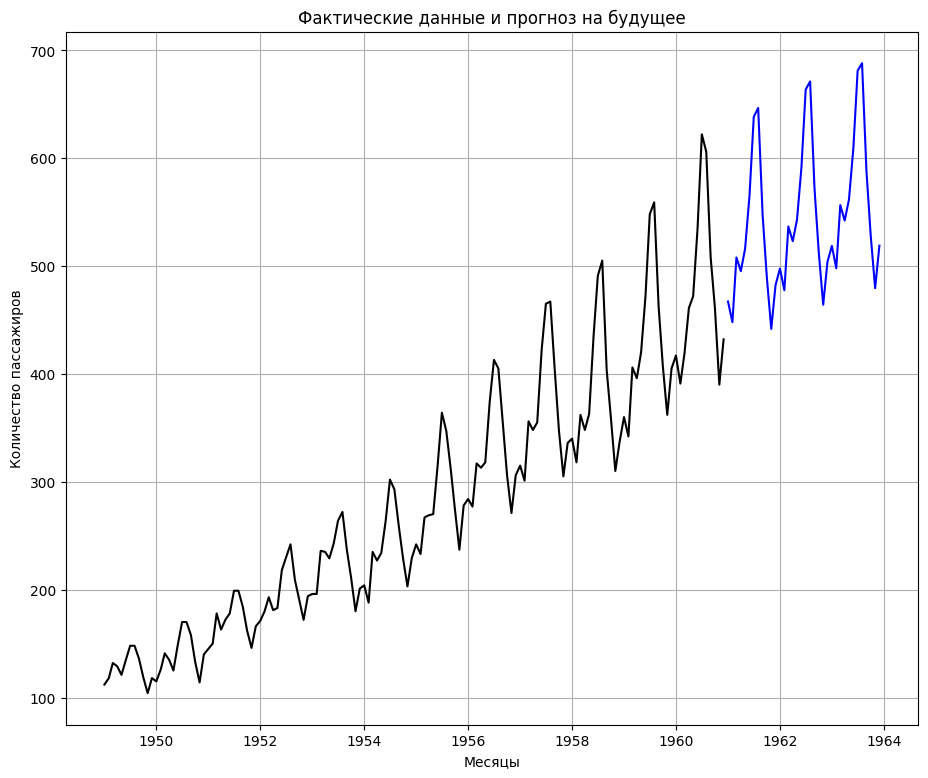

In [38]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(passengers, color = 'black')
plt.plot(forecast, color = 'blue')
 
# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()